Challenge Set 1  Part II   
Topic:        Explore MTA turnstile data  
Date:         04/10/2016  
Name:         Lucia Palova  
Worked with:  Ian London  

# Challenges 5 - 10: Using Pandas

# Reading May and Beg. of June Data

In [2]:
%matplotlib inline
#from matplotlib import pyplot as pt
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
import pandas as pd
import seaborn as sns

import numpy as np

from datetime import datetime, timedelta

import os
import glob

TIME_INTERVAL = '4H'

/home/lucia/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
def load_local_data():
    csv_path = os.path.join(os.getcwd(), 'data-gala/*.txt')
    all_files = glob.glob(csv_path)
    
    all_files = ['/home/lucia/lucia/metis/01-benson/data-gala/01_turnstile_150502.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/02_turnstile_150509.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/03_turnstile_150516.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/04_turnstile_150523.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/05_turnstile_150530.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/06_turnstile_150606.txt']
    
  #  print 'reading data from files:'
  #  for f in all_files:
  #      print f
    
    data = pd.concat((pd.read_csv(f) for f in all_files))
    
    # strip whitespace off column headers (eg 'EXITS               ' has trailing spaces)
    data = data.rename(columns=lambda x: x.strip())
    return data

data = load_local_data()
print "\ngot %i rows total." % len(data)
#data.head()


got 1152582 rows total.


# Transforming data: creating datetime, entries and exits diffs, and sums

In [4]:
# make a datetime column
data['DATETIME'] = pd.to_datetime(data.DATE + ' ' + data.TIME, format="%m/%d/%Y %H:%M:%S")
data.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
191727,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,05:00:00,REGULAR,5554,212,2015-06-05 05:00:00
191728,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,09:00:00,REGULAR,5554,212,2015-06-05 09:00:00
191729,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,13:00:00,REGULAR,5554,212,2015-06-05 13:00:00
191730,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,17:00:00,REGULAR,5554,212,2015-06-05 17:00:00
191731,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,21:00:00,REGULAR,5554,212,2015-06-05 21:00:00


In [5]:
# Calclate new columns ENTRIES_DIFF and EXITS_DIFF for each unique turnstile/device.
# The first entry is NaN, the rest of the entries are the difference from the previous.
turnstile_groupby = data.groupby(['C/A','UNIT','SCP','STATION'])
for diff_field in ('ENTRIES','EXITS'):
    data[diff_field + '_DIFF'] = turnstile_groupby[diff_field].transform(pd.Series.diff)
data.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTRIES_DIFF,EXITS_DIFF
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,00:00:00,REGULAR,5106770,1729635,2015-04-25 00:00:00,NaN,NaN
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,REGULAR,5106810,1729649,2015-04-25 04:00:00,40.0,14.0
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,08:00:00,REGULAR,5106835,1729680,2015-04-25 08:00:00,25.0,31.0


In [6]:
# dropping NA values and all non-REGULAR recordings
# calculating percentage of "regular" values vs. all nonNA values
reg_data = data.dropna()
reg_data = reg_data[ reg_data['DESC'] == 'REGULAR']
print len(reg_data)/float(len(data.dropna()))

0.996898121451


# Dealing with 4-h timestamps : Grouping by station and datetime

In [7]:
#print reg_data.head()
# group by station name and datetime,
station_time_groupby = reg_data.groupby(['STATION','LINENAME','DATETIME','DATE','TIME'], as_index=False)
station_period_totals = station_time_groupby[['ENTRIES_DIFF', 'EXITS_DIFF']].sum()
rounded_times = station_period_totals.set_index('DATETIME').groupby(['STATION','LINENAME'])
rounded_times = rounded_times.resample(TIME_INTERVAL,convention='end').sum()
print len(station_period_totals), len(rounded_times)
station_of_interest = '1 AVE'
print station_of_interest
print 'len before rounding:'
print len(station_period_totals[station_period_totals.STATION == station_of_interest])
print 'len after rounding:'
print len(rounded_times.loc[station_of_interest])
rounded_times = rounded_times.reset_index()
print rounded_times.head()

182442 118042
1 AVE
len before rounding:
257
len after rounding:
251
  STATION LINENAME            DATETIME  ENTRIES_DIFF  EXITS_DIFF
0   1 AVE        L 2015-04-25 04:00:00           3.0        76.0
1   1 AVE        L 2015-04-25 08:00:00           2.0        53.0
2   1 AVE        L 2015-04-25 12:00:00           2.0        54.0
3   1 AVE        L 2015-04-25 16:00:00           4.0        57.0
4   1 AVE        L 2015-04-25 20:00:00           0.0        41.0


# Challenge 5

In [8]:
data_station_5 = reg_data.groupby(['C/A','UNIT','STATION','DATE'])
data_station_5['ENTRIES_DIFF'].sum().head()

C/A   UNIT  STATION        DATE      
A002  R051  LEXINGTON AVE  04/25/2015     9160.0
                           04/26/2015     9546.0
                           04/27/2015    16820.0
                           04/28/2015    17990.0
                           04/29/2015    18273.0
Name: ENTRIES_DIFF, dtype: float64

# Challenge 6

In [9]:
data_station_6 = reg_data.groupby(['STATION','DATE'])
data_station_6 = data_station_6['ENTRIES_DIFF'].sum().reset_index()
data_station_6.DATE = pd.to_datetime(data_station_6.DATE, format="%m/%d/%Y")
data_station_6.head()

,STATION,DATE,ENTRIES_DIFF
0,1 AVE,2015-04-25,11.0
1,1 AVE,2015-04-26,11.0
2,1 AVE,2015-04-27,19127.0
3,1 AVE,2015-04-28,22576.0
4,1 AVE,2015-04-29,23716.0


# Challenge 7

           DATE  ENTRIES_DIFF
2806 2015-04-25       79260.0
2807 2015-04-26       82548.0
2808 2015-04-27      176106.0
2809 2015-04-28      181355.0
2810 2015-04-29      176093.0


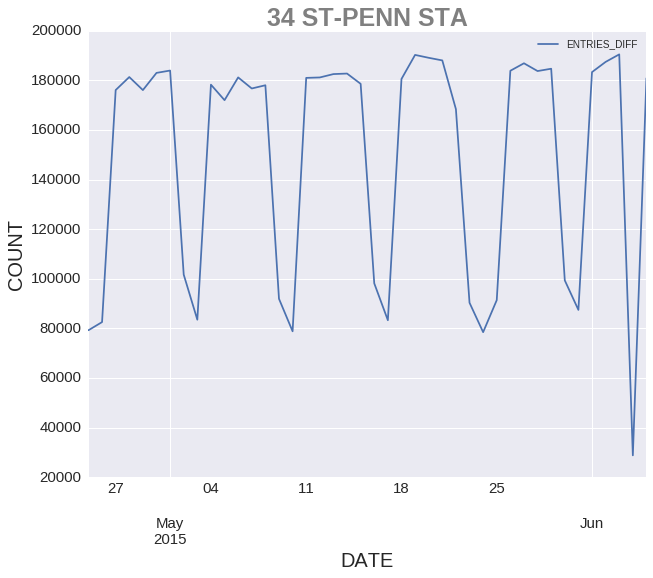

In [10]:
%matplotlib inline
my_station = '34 ST-PENN STA'
#data_station_6.columns
data_station_6_ms = data_station_6[ data_station_6['STATION'] == my_station ][['DATE', 'ENTRIES_DIFF']]
print data_station_6_ms[:5]
#plt.clf()
plt.figure(figsize = (10,8))
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
data_station_6_ms.plot(x='DATE', y='ENTRIES_DIFF', figsize = (10,8))
plt.title(my_station, fontsize=25, color='grey', fontweight='bold')
plt.xlabel('DATE',fontsize=20)
plt.ylabel('COUNT',fontsize=20)

# Challenge 8

/home/lucia/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


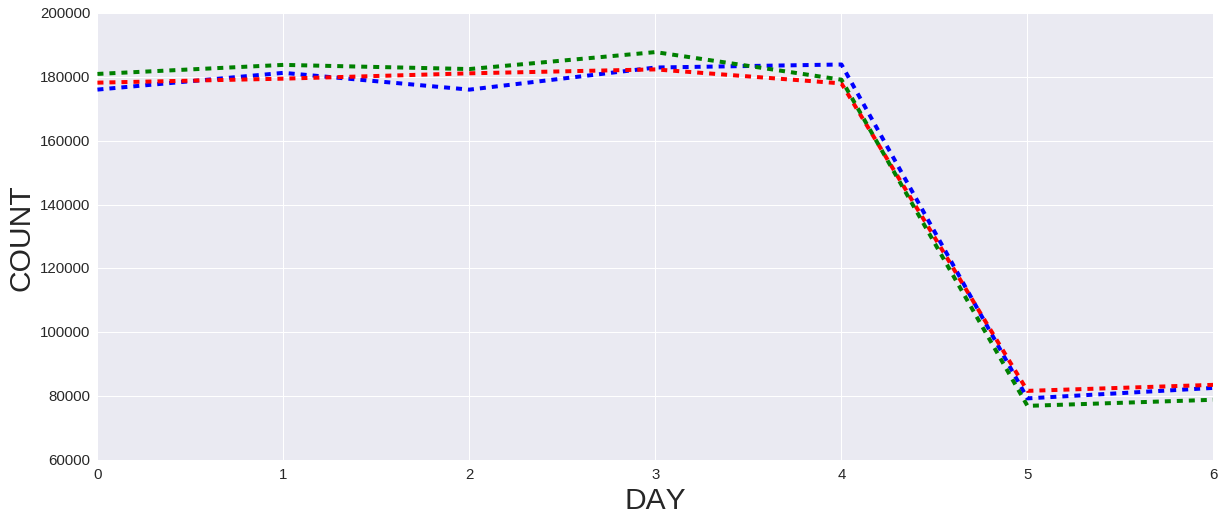

In [11]:
%matplotlib inline
all_files = ['/home/lucia/lucia/metis/01-benson/data-gala/01_turnstile_150502.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/02_turnstile_150509.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/03_turnstile_150516.txt']
                 #'/home/lucia/lucia/metis/01-benson/data-gala/04_turnstile_150523.txt',
                 #'/home/lucia/lucia/metis/01-benson/data-gala/05_turnstile_150530.txt',
                 #'/home/lucia/lucia/metis/01-benson/data-gala/06_turnstile_150606.txt']
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
my_station = '34 ST-PENN STA'
df_list = []
for file in all_files:
#for file in ['/home/lucia/lucia/metis/01-benson/data-gala/01_turnstile_150502.txt']:
    # reads file to dataframe df
    df = pd.read_csv(file)
    # introduces 'DATETIME' column
    df['DATETIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME, format="%m/%d/%Y %H:%M:%S")
    # groups by turnstile, and calculates differences in entries for each turnstile
    turnstile_groupby = df.groupby(['C/A','UNIT','SCP','STATION'])
    df['ENTRIES_DIFF'] = turnstile_groupby['ENTRIES'].transform(pd.Series.diff)
    # filters station of interest
    df = df[df['STATION'] == my_station]
    # introduces 'DAY' column, calculates day from datetime
    df['DAY'] = df['DATETIME'].dt.dayofweek
    ## changes numerical value of day to Mon - Sun
    ## df['DAY'] = df['DAY'].apply(lambda x: days[x])
    # groups data by day and sums all entries per given day
    df = df.groupby(['DAY'])
    df = df['ENTRIES_DIFF'].sum().reset_index()
    df_list.append((list(df['DAY']),list(df['ENTRIES_DIFF'])))

#print df_list    

plt.figure(figsize = (20,8))    #initiate the plot
plt.plot(df_list[0][0],df_list[0][1],'b--',
         df_list[1][0],df_list[1][1],'r--',
         df_list[2][0],df_list[2][1],'g--',
        # df_list[3][0],df_list[3][1],'b--',
        # df_list[4][0],df_list[4][1],'r--',
        # df_list[5][0],df_list[5][1],'g--',
         lw=4)    #generate the plot
#plt.fill(df_list[0][0],df_list[0][1],'b',alpha=0.3)    #fill in the curves
#plt.fill(df_list[1][0],df_list[1][1],'r',alpha=0.3)    #fill in the curves
#plt.fill(df_list[2][0],df_list[2][1],'g',alpha=0.3)    #fill in the curves
plt.xlabel('DAY',fontsize=30)    #add an x label
plt.ylabel('COUNT',fontsize=30)    #add an y label

# Challenge 9 and 10 : Finding Max Entries Stations

## Only identifying station groups by "STATION"

In [12]:
top_20_entries = rounded_times[ (rounded_times['ENTRIES_DIFF'] >= 0) & (rounded_times['ENTRIES_DIFF'] < 1000000)]
top_20_entries = top_20_entries.groupby(['STATION'])
top_20_entries = top_20_entries['ENTRIES_DIFF','EXITS_DIFF'].sum().sort_values(by='ENTRIES_DIFF', ascending=0)
top_20_entries = top_20_entries[:20]
print top_20_entries

                 ENTRIES_DIFF  EXITS_DIFF
STATION                                  
34 ST-PENN STA      6406095.0   5526680.0
42 ST-GRD CNTRL     5421175.0   5054367.0
34 ST-HERALD SQ     4359345.0   4116555.0
86 ST               4303861.0   3391643.0
14 ST-UNION SQ      4133901.0   3696293.0
42 ST-TIMES SQ      3711637.0   3399482.0
42 ST-PA BUS TE     3145886.0   2819216.0
96 ST               3043955.0   2023762.0
59 ST-COLUMBUS      2802928.0   2260833.0
FULTON ST           2767268.0   2380274.0
CANAL ST            2728727.0   2166179.0
125 ST              2672914.0   2490402.0
CHAMBERS ST         2603996.0   1590609.0
23 ST               2482012.0   1906788.0
59 ST               2414748.0   1993960.0
MAIN ST             2267407.0   1887297.0
47-50 ST-ROCK       2102758.0   2174243.0
72 ST               2017840.0   1489414.0
ROOSEVELT AVE       1922060.0   1515332.0
50 ST               1893964.0   1573214.0


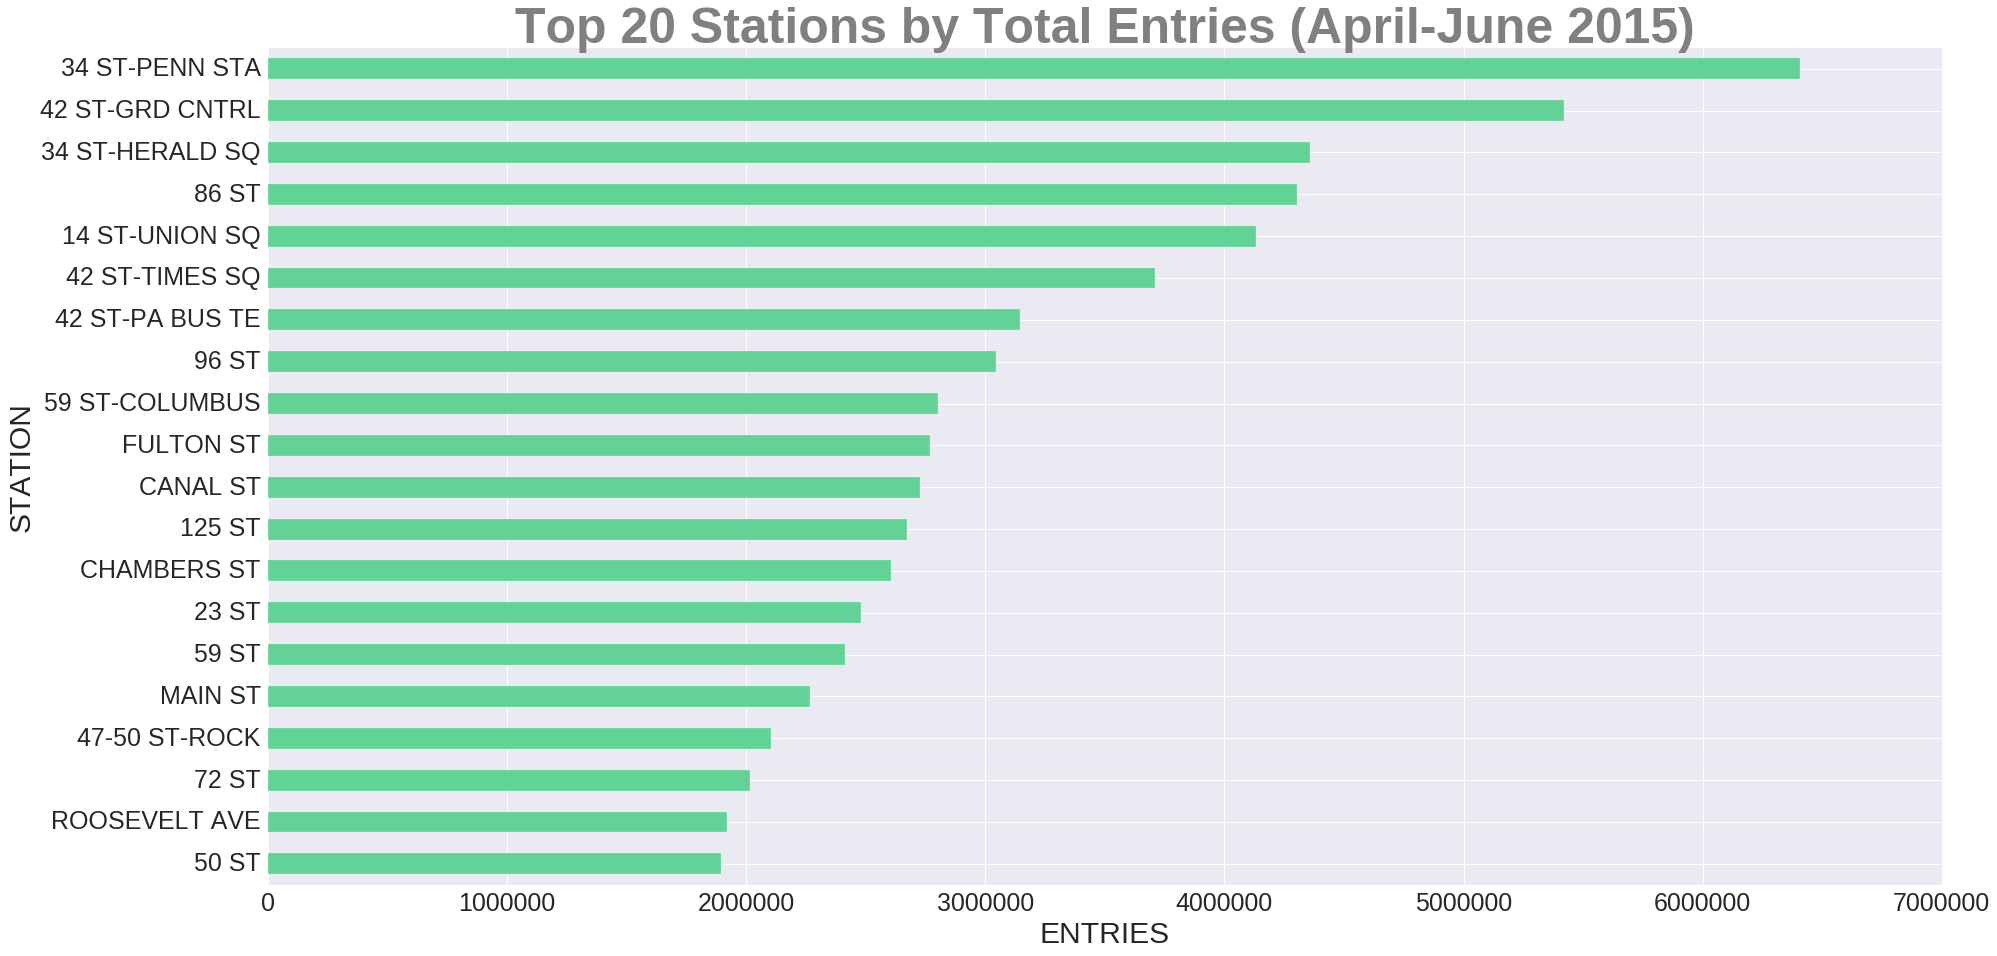

In [13]:
top_20_entries_vals = top_20_entries.ENTRIES_DIFF
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
plt.figure(figsize = (30,15))
plt.title('Top 20 Stations by Total Entries (April-June 2015)',fontsize=50, color='grey', fontweight='bold')
plt.xlabel('ENTRIES',fontsize=30)
plt.ylabel('Station',fontsize=30)
#fig, ax = plt.subplots(figsize=[25,10])
top_20_entries_vals.sort_values(ascending=True).plot(kind='barh', color ='#63d297')
#path = "entries/top_20_entries_stations.png"
#plt.savefig(path)

## Identifying top stations by a unique key: 'STATION' and 'LINENAME'

In [14]:
top_20_entries = rounded_times[ (rounded_times['ENTRIES_DIFF'] >= 0) & (rounded_times['ENTRIES_DIFF'] < 1000000)]
top_20_entries = top_20_entries.groupby(['STATION','LINENAME'])
top_20_entries = top_20_entries['ENTRIES_DIFF','EXITS_DIFF'].sum().sort_values(by='ENTRIES_DIFF', ascending=0)
top_20_entries = top_20_entries[:20]
print top_20_entries

                             ENTRIES_DIFF  EXITS_DIFF
STATION         LINENAME                             
42 ST-GRD CNTRL 4567S           5421175.0   5054367.0
34 ST-HERALD SQ BDFMNQR         4359345.0   4116555.0
42 ST-TIMES SQ  1237ACENQRS     3285044.0   2750291.0
34 ST-PENN STA  ACE             3088817.0   2824463.0
14 ST-UNION SQ  LNQR456         2776875.0   2438597.0
42 ST-PA BUS TE ACENQRS1237     2608607.0   2312627.0
86 ST           456             2542337.0   2168415.0
59 ST-COLUMBUS  ABCD1           2274714.0   1803936.0
MAIN ST         7               2267407.0   1887297.0
47-50 ST-ROCK   BDFM            2102758.0   2174243.0
34 ST-PENN STA  123ACE          2007933.0   1426732.0
ROOSEVELT AVE   EFMR7           1922060.0   1515332.0
59 ST           456NQR          1919109.0   1705889.0
CANAL ST        JNQRZ6          1787151.0   1308125.0
W 4 ST-WASH SQ  ABCDEFM         1721922.0   1655868.0
72 ST           123             1635258.0   1174465.0
96 ST           123         

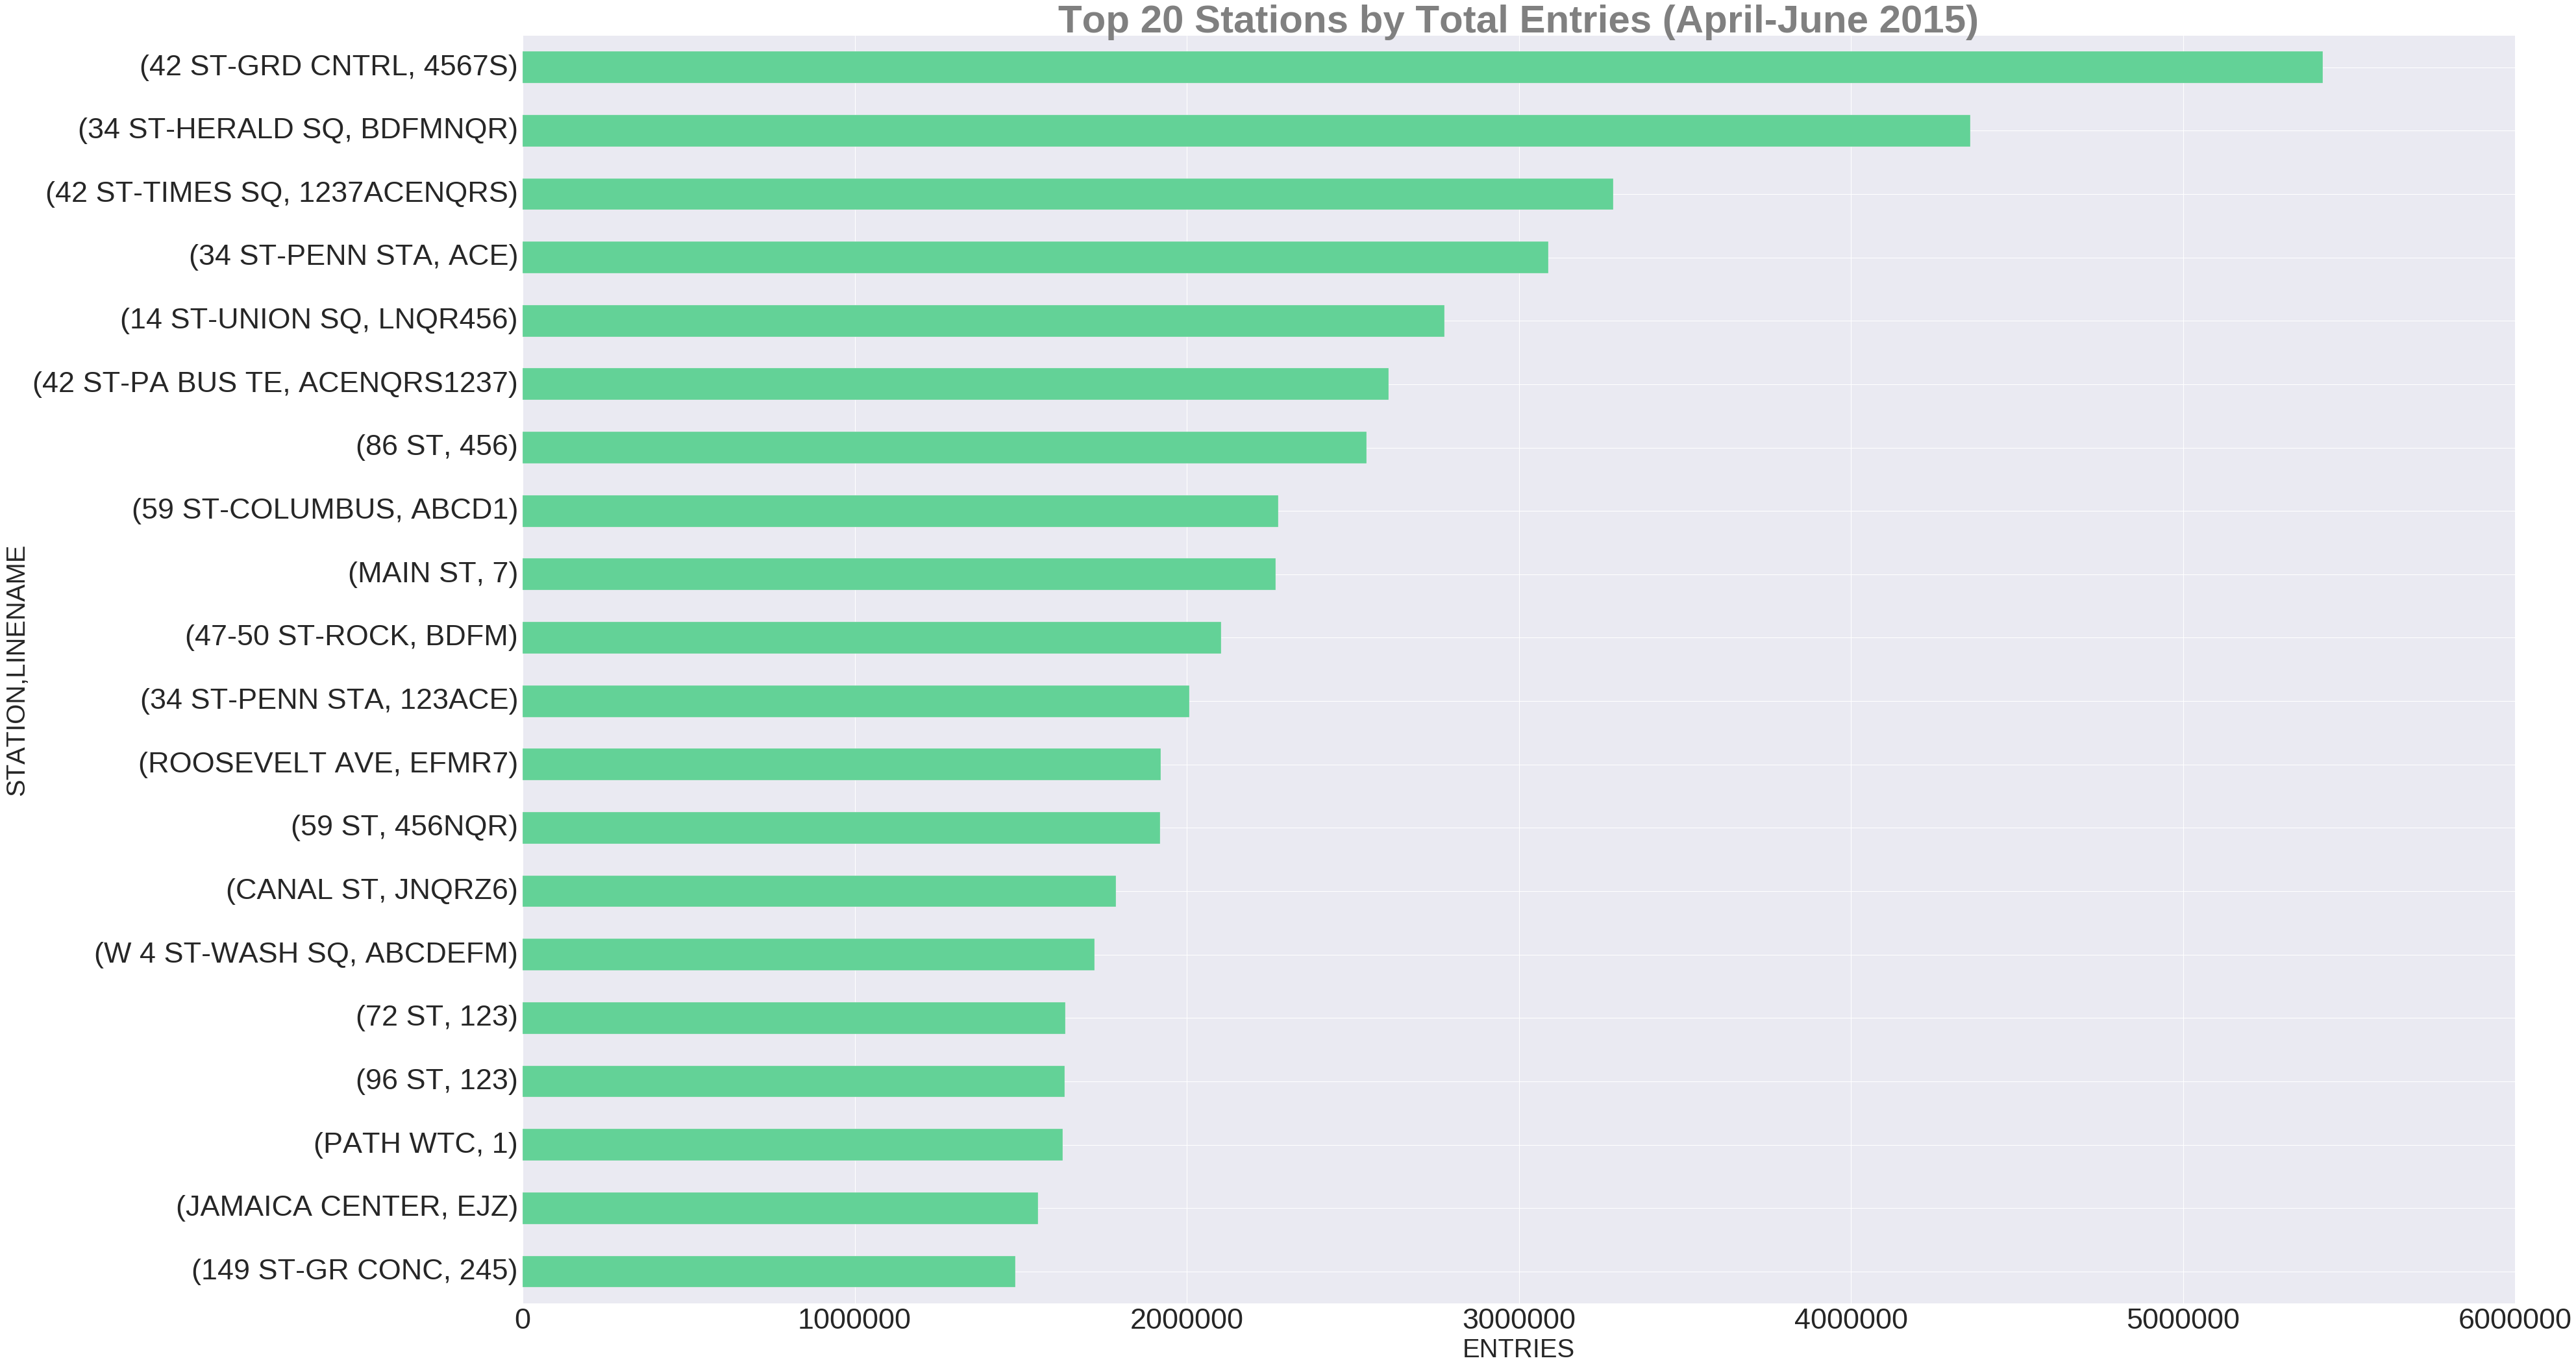

In [15]:
top_20_entries_vals = top_20_entries.ENTRIES_DIFF
matplotlib.rc('xtick', labelsize=45) 
matplotlib.rc('ytick', labelsize=45) 
plt.figure(figsize = (55,35))
plt.title('Top 20 Stations by Total Entries (April-June 2015)',fontsize=60, color='grey', fontweight='bold')
plt.xlabel('ENTRIES',fontsize=40)
plt.ylabel('Station',fontsize=40)
#fig, ax = plt.subplots(figsize=[25,10])
top_20_entries_vals.sort_values(ascending=True).plot(kind='barh', color ='#63d297')
#path = "entries/top_20_entries_lines_stations.png"
#plt.savefig(path)